In [222]:
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import date
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from nltk.stem import WordNetLemmatizer 
import re
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import shap

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# Add the json file format for credentials
creds = ServiceAccountCredentials.from_json_keyfile_name(r'C:\Users\vamsi\GSA_LinkedIn_WebScrapping\new_project_scraping\ucdavismsba-174d7e753d10.json', scope)

# authorize the clientsheet 
client = gspread.authorize(creds)

sheet_key = '17vIVA7djuT0A9PHlxLT53_kib0Yquv3UhkTIOQo_lLY'

# open a google sheet
gs = client.open_by_key(sheet_key)

worksheet = gs.worksheet('jobs')

In [8]:
df_jobs = get_as_dataframe(worksheet=worksheet)

In [31]:
pd.set_option("display.max_rows",50)

In [27]:
df_jobs.drop_duplicates(subset=['job_description'],inplace=True)

In [28]:
df_jobs.shape

(231, 17)

In [53]:
def generalized_roles(row):
    if 'DATA SCIENTIST' in row['job_title'].upper() or 'DATA SCIENCE' in row['job_title'].upper():
        job_role = 'Data Scientist'
    elif 'BUSINESS ANALYST' in row['job_title'].upper() or 'BUSINESS INSIGHTS' in row['job_title'].upper()\
        or ' BI ' in row['job_title'].upper() or 'BUSINESS INTELLIGENCE ANALYST' in row['job_title'].upper() :
        job_role =  'Business Analyst'
    elif 'DATA ANALYST' in row['job_title'].upper() or 'ANALYST' in row['job_title'].upper():
        job_role =  'Data Analyst'
    else:
        job_role =  'Unidentified'
    return job_role

In [57]:
df_jobs=df_jobs[df_jobs['target_variable']!='Unidentified']

In [242]:
def text_prep(jd):
    jd = re.sub("[^a-zA-Z]", " ", jd)
    words_to_remove = ['business analyst','data', 'data scientist', 'science','analyst', 'scientist','scientists','data analyst','business','data science','machine learning','machine']
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', flags=re.IGNORECASE)
    jd = pattern.sub('', jd)
    return jd

In [243]:
df_jobs['cleaned_text'] = df_jobs['job_description'].apply(lambda x: text_prep(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [244]:
df_jobs['cleaned_text'] 

3      If you re ready to be part of our legacy of ho...
5      The Save Mart Companies is one of the largest ...
6      This is Adyen Adyen provides payments    and f...
11     Are you an experienced  passionate pioneer in ...
13       Lead II    Analysis Born digital  UST transf...
                             ...                        
481    STAFF     ENGINEER  Remote  USA  or Flex  Offi...
485                Through our dedicated associates  ...
487    Our client is a biotech startup that is lookin...
493    The Position  What you ll be working on    pro...
495    Who We Are Okcoin is one of the world s larges...
Name: cleaned_text, Length: 212, dtype: object

In [245]:
le = preprocessing.LabelEncoder()
y=le.fit_transform(df_jobs['target_variable'])

In [246]:
df_train, df_test, y_train, y_test = train_test_split(df_jobs['cleaned_text'], y, test_size=0.20, random_state=42,stratify=y)

In [263]:
tv = TfidfVectorizer(
                    ngram_range = (1,3),
                    sublinear_tf = True,
                    lowercase=True,
                    stop_words='english',
                    
                    min_df=0.1,
                    max_features = 4000)

In [264]:
train_tv = tv.fit_transform(df_train)
test_tv = tv.transform(df_test)

In [265]:
train_tv

<169x933 sparse matrix of type '<class 'numpy.float64'>'
	with 36086 stored elements in Compressed Sparse Row format>

In [266]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0,oob_score=True)
clf.fit(train_tv, y_train)

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

In [267]:
clf.oob_score_

0.757396449704142

In [268]:
y_pred = clf.predict(test_tv)

In [269]:
cm = confusion_matrix(y_test, y_pred)

In [270]:
cm

array([[ 7,  4,  0],
       [ 1, 16,  1],
       [ 0,  4, 10]], dtype=int64)

In [271]:
importances = clf.feature_importances_

In [272]:
importances

array([5.82916856e-04, 2.09522583e-03, 7.09462425e-05, 6.02277865e-04,
       9.08948693e-04, 2.77422886e-04, 7.76698246e-04, 7.94339173e-04,
       5.94604082e-04, 7.06734896e-04, 5.86416220e-04, 8.48033151e-04,
       3.00844166e-04, 5.70487918e-04, 2.12555499e-04, 9.26394071e-04,
       4.35243417e-04, 3.43566178e-04, 4.72352822e-04, 4.51877777e-04,
       1.09077382e-03, 8.37844623e-04, 4.17832234e-04, 3.58221223e-03,
       5.41507346e-04, 4.47811482e-04, 8.64366282e-04, 1.28946686e-03,
       5.32587056e-03, 2.88319578e-04, 1.01274136e-03, 2.02133225e-03,
       4.63259926e-04, 9.28686781e-04, 1.76903316e-03, 1.13782745e-03,
       4.91780404e-03, 4.84369805e-04, 1.17674399e-03, 7.07968176e-04,
       6.75554228e-04, 2.92281428e-04, 5.37177402e-04, 1.56744261e-04,
       8.17174339e-04, 1.01599508e-03, 9.94729906e-04, 1.17871017e-03,
       4.14879831e-03, 1.35490061e-03, 6.46787766e-04, 4.35475744e-04,
       2.73858892e-04, 1.43422699e-03, 7.50950602e-04, 1.65001984e-04,
      

In [273]:
len(importances[indices][:10])

IndexError: index 2919 is out of bounds for axis 0 with size 933

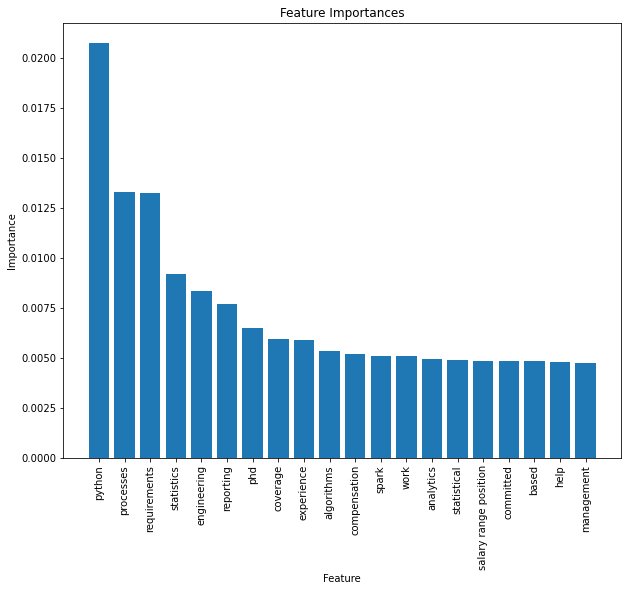

In [274]:
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar chart of feature importances
plt.figure(figsize=(10,8))
plt.bar(range(20), importances[indices][:20])

# Add feature names as x-axis labels
plt.xticks(range(20), [tv.get_feature_names_out()[i] for i in indices][:20], rotation=90)

# Set axis labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [275]:
le.classes_[0]

'Business Analyst'

Business Analyst


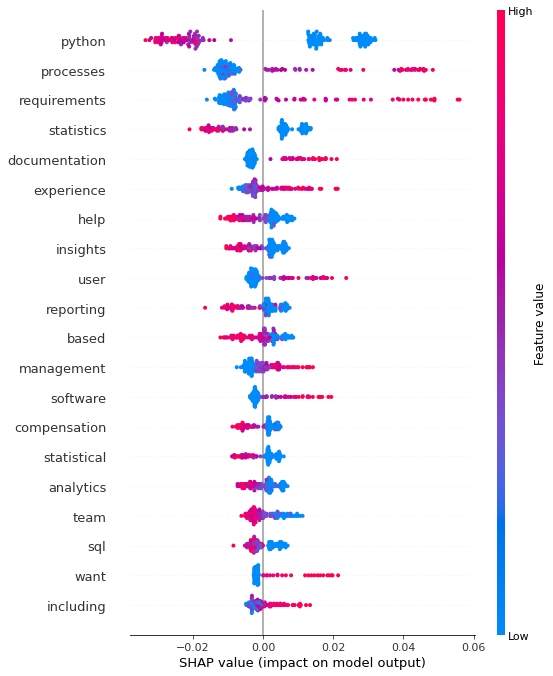

Data Analyst


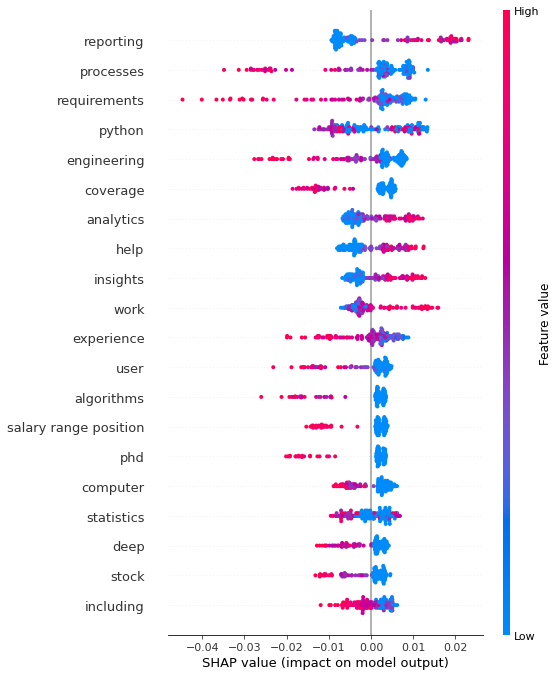

Data Scientist


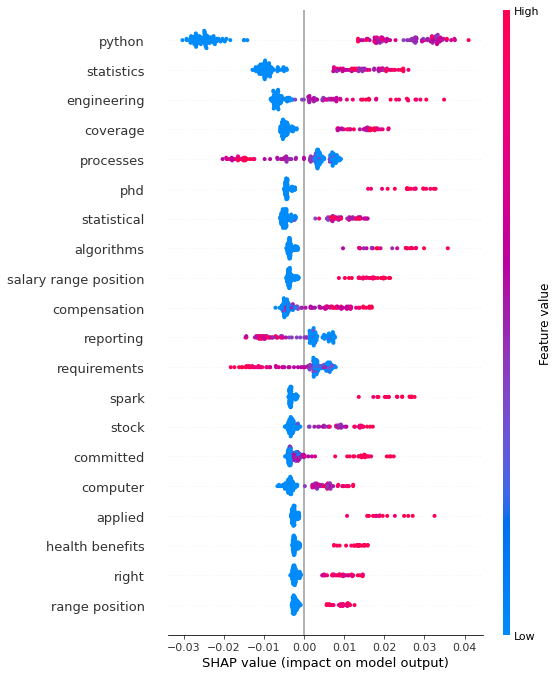

In [276]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(train_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(train_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())

Business Analyst


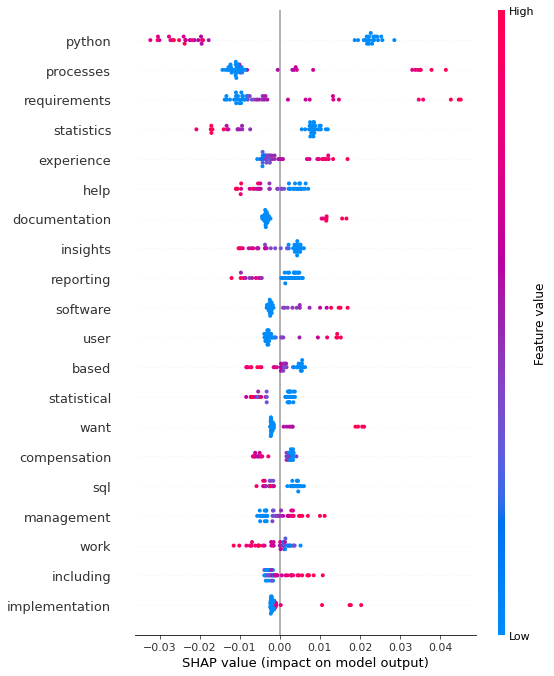

Data Analyst


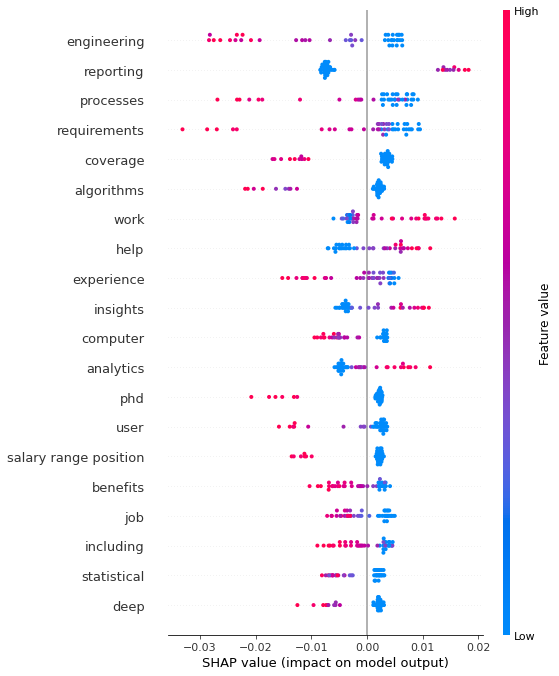

Data Scientist


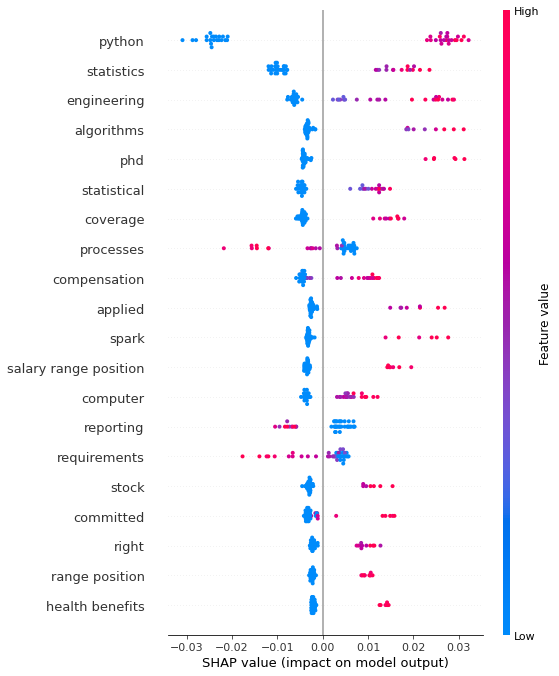

In [277]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(test_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(test_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())

In [262]:
# Calculate the feature importance for each class
class_0_importance = np.abs(shap_values[0]).mean(axis=0)
class_1_importance = np.abs(shap_values[1]).mean(axis=0)
class_2_importance = np.abs(shap_values[2]).mean(axis=0)

# Print the feature importance for each class
print('Class 0 Feature Importance:')
for feature, importance in zip(tv.get_feature_names_out(), class_0_importance):
    print(f'{feature}: {importance}')

print('\nClass 1 Feature Importance:')
for feature, importance in zip(tv.get_feature_names_out(), class_1_importance):
    print(f'{feature}: {importance}')

Class 0 Feature Importance:
abilities: 0.00012594643151968464
ability: 0.000866749677517141
ability analyze: 0.00013891432234269254
ability communicate: 2.465904715606008e-05
ability customers: 0.0
ability customers experience: 5.127752580382347e-06
ability lead: 1.7389116037534554e-05
ability manage: 2.5450454925362702e-05
ability think: 0.0
ability work: 0.0001059889241763873
ability work independently: 3.2778526023775186e-06
able: 0.00059968344906115
able work: 4.448477804587759e-05
abudhabi: 4.467726484810873e-06
abudhabi sharjah: 3.5001272007959606e-05
abudhabi sharjah london: 6.061942003635312e-06
accelerate: 2.8736903304328378e-05
accept: 4.701689900525897e-05
accept party: 9.95343878868552e-06
accept party resumes: 5.7457840644504105e-06
acceptance: 0.001205661495798705
access: 0.0002767134361020146
accessible: 0.00012123018253276988
accident: 1.6010100880391664e-05
accommodation: 0.0005355883143929902
accommodation reach: 0.0
accommodation reach usrc: 0.0
accommodations: 0.000

lisbon porto braga: 1.99874496450477e-05
list: 2.2558487160773676e-05
listed: 0.0002602545673144676
listed minimum: 2.002621311347291e-05
listed minimum qualifications: 1.1158805848826773e-05
listed preferred: 0.0
listed preferred qualifications: 8.691367930448495e-06
live: 1.4986554033537952e-05
live better: 3.6093527819824767e-06
liverpool: 5.101905910946845e-06
liverpool edinburgh: 1.7644657951943432e-05
liverpool edinburgh kiev: 7.090932645373695e-06
lives: 4.146051475445447e-05
ll: 0.00012731150186608224
ll need: 3.763864556455701e-05
ll need succeed: 0.0
llnl: 0.0
local: 9.586659264809372e-05
local law: 4.028585147438446e-05
local laws: 6.574080004270002e-05
located: 0.00015421209976701486
location: 0.0014988948747969946
location agoda: 2.3591582587410895e-05
location agoda responsible: 0.0
location base: 7.300416060338697e-05
location base pay: 0.0
locations: 0.0005427028280970653
lodz: 5.622920234376644e-06
lodz wroclaw: 1.3580471939222213e-05
lodz wroclaw poznan: 0.0
london: 0

alrayyan bucharest moscow: 0.0
amadora: 0.0
amadora almada: 1.3677537407426394e-05
amadora almada doha: 1.823068926775309e-05
amazon: 3.7333174882797124e-05
ambiguity: 0.00013044770003479845
ambiguous: 4.034736205176098e-05
ambitious: 1.708295494604745e-05
america: 0.00010653041777002837
amman: 5.2768379062902326e-06
amman irbid: 8.381780274874311e-06
amman irbid riga: 1.769455565342165e-05
amounts: 0.0
amsterdam: 1.2470894148572203e-05
amsterdam oslo: 2.7434988135105832e-05
amsterdam oslo jerusalem: 1.7383311439069988e-05
analyses: 0.00031996575504607917
analysis: 0.0009492816781779601
analysis intelligence: 3.0228769160735343e-05
analysis intelligence bi: 6.849106476685497e-06
analysis sql: 6.4073340826736404e-06
analysis sql analytics: 1.4581025162164298e-05
analysis tools: 5.357626232457227e-05
analysts: 8.354340941673227e-05
analytic: 0.0011057340745570506
analytical: 0.00037723992212928577
analytical problem: 3.6458074641965794e-05
analytical problem solving: 4.325507967463684e-0

globally: 0.00012176895243553458
globally based: 1.2284786156505891e-05
globally based asia: 0.0
globe: 0.0
globe does: 0.0
globe does workplace: 5.901513690185875e-05
goal: 0.00017302256008096557
goal committed: 2.806040361943762e-05
goal committed celebrating: 9.491300645275691e-06
goals: 0.00034710561423183554
good: 0.0003701149849454313
google: 7.821227071295276e-05
google analytics: 3.2508837383433205e-05
governance: 5.9910886768173974e-05
government: 5.041848724689082e-05
graph: 6.776805745953198e-05
graz: 2.0314310130688026e-05
graz linz: 0.0
graz linz baku: 3.649343803485272e-06
great: 0.00031926207334074136
great benefits: 1.8143247069405806e-05
great benefits happier: 8.454434918822538e-07
great place: 7.723688651647671e-05
great place work: 4.16687844236405e-05
greater: 2.931609695261607e-05
ground: 8.979681039049598e-05
group: 0.00016787764471655088
groups: 0.00018438495622270676
grow: 0.00015851351857353748
growing: 0.001147608963144533
growing team: 1.7718221585117614e-05

stock purchase: 0.0002642404293231291
stock purchase company: 0.0
stock purchase plan: 0.00012469125736503915
stock units: 0.0010048667261296483
stock units bytedance: 1.3397968917497832e-05
stockholm: 1.657412153598521e-05
stockholm zurich: 2.7969038977952162e-05
stockholm zurich geneva: 0.0
store: 0.0
stores: 0.0
stories: 5.419295257266564e-05
story: 0.0001614631070869435
storytelling: 6.694053659666781e-05
stra: 0.0
stra anls: 0.0
stra anls mrkt: 4.8344061619804614e-06
strategic: 0.0009646612309921018
strategies: 0.00014700329238590963
strategy: 0.0004913023777620197
strength: 6.0144258661220344e-05
strengths: 3.803476068179568e-05
strengths experience: 1.6005952902196182e-05
strengths experience passionate: 2.1148172930636792e-05
strive: 4.365371736007155e-05
striving: 2.1548749476736943e-05
strong: 0.0006980758440192508
strong analytical: 4.463280680708174e-05
strong analytical skills: 4.1669136538206404e-05
strong communication: 7.665853570052933e-05
strong understanding: 2.26588